## TensorFlow with Keras

In [380]:
# Import libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler # scaling data
from tensorflow import keras
from tensorflow.python.keras.models import Sequential # creating & training a model
from tensorflow.python.keras.layers import Dense #Input
from tensorflow.python.keras.callbacks import EarlyStopping
# Cross-Validation
from scikeras.wrappers import KerasClassifier

from sklearn.model_selection import cross_val_score, StratifiedKFold

#from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.activations import sigmoid
import tensorflow as tf; tf.keras
#import numpy

import tensorflow as tf; tf.keras

import warnings
warnings.filterwarnings("ignore")
# Settings
import sys
sys.path.append('../src')
# Import feature engineering functions
from preprocessing import preprocess_data, drop_columns

In [381]:
# Fix the 'DistributedDatasetInterface' Error
#from tensorflow.python.keras.engine import data_adapter
#def _is_distributed_dataset(ds):
    #return isinstance(ds, data_adapter.input_lib.DistributedDatasetSpec)
#data_adapter._is_distributed_dataset = _is_distributed_dataset

In [382]:
# DATA INGESTION

# Fetch the data
train_df = pd.read_csv('../data/train.csv')
test_df = pd.read_csv('../data/test.csv')

In [383]:
# Check the DataFrame
train_df.tail(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
881,882,0,3,"Markun, Mr. Johann",male,33.0,0,0,349257,7.8958,NaN,S
882,883,0,3,"Dahlberg, Miss. Gerda Ulrika",female,22.0,0,0,7552,10.5167,NaN,S
883,884,0,2,"Banfield, Mr. Frederick James",male,28.0,0,0,C.A./SOTON 34068,10.5000,NaN,S
884,885,0,3,"Sutehall, Mr. Henry Jr",male,25.0,0,0,SOTON/OQ 392076,7.0500,NaN,S
885,886,0,3,"Rice, Mrs. William (Margaret Norton)",female,39.0,0,5,382652,29.1250,NaN,Q
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.7500,NaN,Q


In [384]:
# Concatenate both training and test data
data = pd.concat([train_df,test_df]).reset_index(drop=True)

In [385]:
# FEATURE ENGINEERING
data = preprocess_data(data)
data = drop_columns(data)
data.head()

,Survived,Age,SibSp,Parch,Fare,Embarked_S,FamilySize,Sex_male,Pclass_2,Pclass_3
0,0.0,22.0,1,0,7.2500,1,2,1,0,1
1,1.0,38.0,1,0,71.2833,0,2,0,0,0
2,1.0,26.0,0,0,7.9250,1,1,0,0,1
3,1.0,35.0,1,0,53.1000,1,2,0,0,0
4,0.0,35.0,0,0,8.0500,1,1,1,0,1


In [ ]:
# Split the training and test data again
#train_df = data[data.Survived != -1].reset_index(drop=True) 
#test_df = data[data.Survived == -1].reset_index(drop=True)
train_df = data[data['Survived'].notnull()].reset_index(drop=True)
test_df = data[data['Survived'].isnull()].reset_index(drop=True)

In [387]:
train_df.isnull().sum()

Survived      0
Age           0
SibSp         0
Parch         0
Fare          0
Embarked_S    0
FamilySize    0
Sex_male      0
Pclass_2      0
Pclass_3      0
dtype: int64

In [388]:
test_df.isnull().sum()

Survived      418
Age             0
SibSp           0
Parch           0
Fare            0
Embarked_S      0
FamilySize      0
Sex_male        0
Pclass_2        0
Pclass_3        0
dtype: int64

In [ ]:
# CROSS-VALIDATION

#X = train_df[['Pclass', 'Age', 'Fare', 'SibSp', 'Parch']].values
# Define features (X) and target (y)
X = train_df.drop(['Survived'], axis=1).values
y = train_df['Survived'].values

In [391]:
# Split into train and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

In [392]:
X_train.shape

(596, 9)

In [393]:
X_valid.shape

(295, 9)

In [394]:
#help(MinMaxScaler)

In [395]:
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_valid = scaler.transform(X_valid)

In [396]:
X_train.min()

0.0

In [ ]:
# BUILDING A MODEL with 3 layers
def build_model():
    model=Sequential() #help(Sequential)
    model.add(Dense(64, activation='relu', input_dim=X_train.shape[1]))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(64, activation='relu')) 
    model.add(Dense(1, activation='sigmoid')) # activation for binary classification problem

    #model.compile(optimizer='rmsprop', loss='binary_crossentropy') # loss for binary classification problem
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [399]:
model = KerasClassifier(model=build_model, epochs=20, batch_size=5, verbose=1)

In [400]:
# Define Early Stopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [ ]:
# CROSS-VALIDATION
# Stratified K-Fold Cross-Validation - GIVES COMPILE ERROR
#estimate = KerasClassifier(build_fn=build_model, epochs=20, batch_size=5, verbose=1)
#kfold = StratifiedKFold(n_splits=10, shuffle=True)
#results = cross_val_score(model, X, y, cv=kfold)
# Print the results
#print("Results: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

In [ ]:
# TRAIN MODEL
model = build_model()
history = model.fit(X_train, y_train, 
    validation_data=(X_valid, y_valid),
    epochs=50, batch_size=10, 
    callbacks=[early_stop], 
    verbose=1
)

Epoch 1/50
60/60 [==============================] - 0s 2ms/step - loss: 0.5738 - accuracy: 0.6829 - val_loss: 0.5090 - val_accuracy: 0.7831
Epoch 2/50
60/60 [==============================] - 0s 623us/step - loss: 0.4839 - accuracy: 0.7903 - val_loss: 0.4581 - val_accuracy: 0.7932
Epoch 3/50
60/60 [==============================] - 0s 600us/step - loss: 0.4510 - accuracy: 0.7919 - val_loss: 0.4383 - val_accuracy: 0.8169
Epoch 4/50
60/60 [==============================] - 0s 591us/step - loss: 0.4487 - accuracy: 0.8087 - val_loss: 0.4495 - val_accuracy: 0.8068
Epoch 5/50
60/60 [==============================] - 0s 615us/step - loss: 0.4301 - accuracy: 0.8121 - val_loss: 0.4272 - val_accuracy: 0.8203
Epoch 6/50
60/60 [==============================] - 0s 578us/step - loss: 0.4421 - accuracy: 0.8154 - val_loss: 0.4486 - val_accuracy: 0.7932
Epoch 7/50
60/60 [==============================] - 0s 576us/step - loss: 0.4222 - accuracy: 0.8188 - val_loss: 0.4248 - val_accuracy: 0.8136
Epoch 8/

In [ ]:
# EVALUATION
# Evaluate model on the test data
test_loss, test_acc = model.evaluate(X_valid, y_valid, verbose=0)
print(f"Test Accuracy: {test_acc:.2f}")


Test Accuracy: 0.82


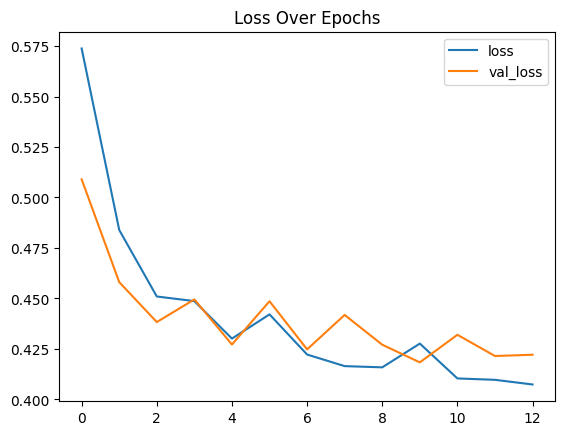

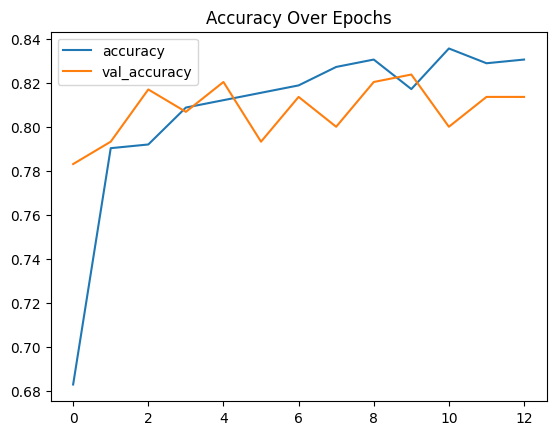

In [407]:
# Plot training history
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot(title='Loss Over Epochs')
plt.show()
history_df[['accuracy', 'val_accuracy']].plot(title='Accuracy Over Epochs')
plt.show()

In [408]:
# Model evaluation on the test set
y_pred = model.predict(X_valid)
y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary class (0 or 1)

In [409]:
# Calculate the metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
accuracy = accuracy_score(y_valid, y_pred)
precision = precision_score(y_valid, y_pred)
recall = recall_score(y_valid, y_pred)
f1 = f1_score(y_valid, y_pred)
roc_auc = roc_auc_score(y_valid, y_pred)
conf_matrix = confusion_matrix(y_valid, y_pred)

In [410]:
# Print the metrics
print("Model Evaluation Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix)

Model Evaluation Metrics:
Accuracy: 0.8237
Precision: 0.8675
Recall: 0.6372
F1 Score: 0.7347
ROC AUC: 0.7884

Confusion Matrix:
[[171  11]
 [ 41  72]]


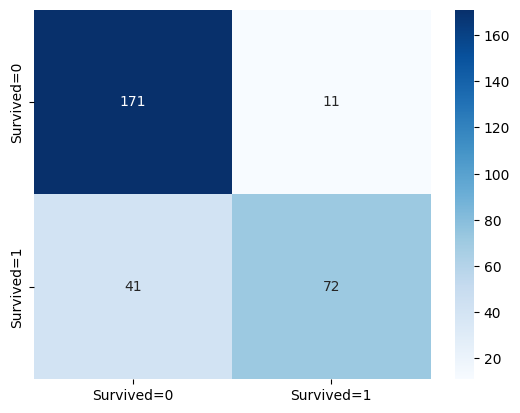

In [411]:
# Optional: Display confusion matrix using seaborn heatmap
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Survived=0', 'Survived=1'], yticklabels=['Survived=0', 'Survived=1'])
plt.show()